<span style='background:#DCEDC8; font-size:30px; display:block; border-left:40px solid #C5E1A5; padding-left:40px;'>
<b>
    Download multiple meteoscreening variables
</b>
</span>

**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# **Auto-settings**

## Data settings

In [1]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [2]:
from datetime import datetime
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.78.0
dbc-influxdb version: v0.11.2
Reading configuration files was successful.
Connection to database works.


</br>

# **Download**

In [3]:
OUTFILE = f"meteo6_2005-2023.csv"

## Download FLUXNET meteo data (2005-2020)

In [4]:
%%time
data_simple_fluxnet, data_detailed_fluxnet, assigned_measurements_fluxnet = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA'],
    fields=['TA_F', 'RH', 'LW_IN_F', 'PPFD_IN', 'SW_IN_F', 'PA_F'],
    start='2005-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2021-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='fluxnet_ww2020'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['TA_F', 'RH', 'LW_IN_F', 'PPFD_IN', 'SW_IN_F', 'PA_F']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version fluxnet_ww2020
    between 2005-01-01 00:00:01 and 2021-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2005-01-01T00:00:01+01:00, stop: 2021-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "fluxnet_ww2020") |> filter(fn: (r) => r["_field"] == "TA_F" or r["_field"] == "RH" or r["_field"] == "LW_IN_F" or r["_field"] == "PPFD_IN" or r["_field"] == "SW_IN_F" or r["_field"] == "PA_F") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
querystring was constructed from:
    bucketstring: from(bucke

In [5]:
data_simple_fluxnet

,LW_IN_F,PA_F,PPFD_IN,RH,SW_IN_F,TA_F
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.367,98.223,NaN,NaN,0.0,2.139
2005-01-01 01:00:00,331.367,98.229,NaN,NaN,0.0,2.126
2005-01-01 01:30:00,324.823,98.235,NaN,NaN,0.0,2.114
2005-01-01 02:00:00,324.823,98.208,NaN,NaN,0.0,2.090
2005-01-01 02:30:00,334.816,98.181,NaN,NaN,0.0,2.066
...,...,...,...,...,...,...
2020-12-31 22:00:00,327.059,NaN,0.012177,100.0,0.0,-0.060
2020-12-31 22:30:00,325.682,NaN,0.015688,100.0,0.0,-0.748
2020-12-31 23:00:00,325.802,NaN,0.015338,100.0,0.0,-0.607


## Download meteo data from diive meteoscreening (2021-2023)

In [6]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA'],
    fields=['TA_T1_2_1', 'RH_T1_2_1', 'LW_IN_T1_2_1', 'PPFD_IN_T1_2_2', 'SW_IN_T1_2_1', 'PA_GF1_0.9_1'],
    start='2021-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2024-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='meteoscreening_diive'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['TA_T1_2_1', 'RH_T1_2_1', 'LW_IN_T1_2_1', 'PPFD_IN_T1_2_2', 'SW_IN_T1_2_1', 'PA_GF1_0.9_1']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version meteoscreening_diive
    between 2021-01-01 00:00:01 and 2024-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2021-01-01T00:00:01+01:00, stop: 2024-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_2_1" or r["_field"] == "RH_T1_2_1" or r["_field"] == "LW_IN_T1_2_1" or r["_field"] == "PPFD_IN_T1_2_2" or r["_field"] == "SW_IN_T1_2_1" or r["_field"] == "PA_GF1_0.9_1") |> pivot(rowKey:["_time"], columnKey: ["_field"],

In [7]:
data_simple

,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_END,,,,,,
2021-01-01 00:30:00,332.179450,958.107523,0.0,100.000000,0.0,0.156080
2021-01-01 01:00:00,329.543557,958.088840,0.0,100.000000,0.0,0.102816
2021-01-01 01:30:00,328.928400,958.323920,0.0,100.000000,0.0,0.105138
2021-01-01 02:00:00,331.492063,958.425240,0.0,99.998978,0.0,0.168548
2021-01-01 02:30:00,332.917923,958.625800,0.0,99.999973,0.0,0.214706
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407107,964.969617,0.0,99.461884,0.0,1.540578
2023-12-31 22:30:00,327.958383,965.049553,0.0,98.875075,0.0,2.051889
2023-12-31 23:00:00,328.605910,965.261047,0.0,97.569925,0.0,2.223067


</br>

# **Adjust units** (if needed)

In [8]:
# Units for PA from meteoscreening_diive are given in mbar (hPa), but are needed in kPa
data_simple['PA_GF1_0.9_1'] = data_simple['PA_GF1_0.9_1'].divide(10)
data_simple

,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_END,,,,,,
2021-01-01 00:30:00,332.179450,95.810752,0.0,100.000000,0.0,0.156080
2021-01-01 01:00:00,329.543557,95.808884,0.0,100.000000,0.0,0.102816
2021-01-01 01:30:00,328.928400,95.832392,0.0,100.000000,0.0,0.105138
2021-01-01 02:00:00,331.492063,95.842524,0.0,99.998978,0.0,0.168548
2021-01-01 02:30:00,332.917923,95.862580,0.0,99.999973,0.0,0.214706
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407107,96.496962,0.0,99.461884,0.0,1.540578
2023-12-31 22:30:00,327.958383,96.504955,0.0,98.875075,0.0,2.051889
2023-12-31 23:00:00,328.605910,96.526105,0.0,97.569925,0.0,2.223067


</br>

# **Rename variables for merging and for use in EddyPro**

In [9]:
renaming_dict = {
    'LW_IN_F': 'Lwin_1_1_1',
    'PPFD_IN': 'PPFD_1_1_1',
    'RH': 'RH_1_1_1',
    'SW_IN_F': 'Rg_1_1_1',
    'TA_F': 'Ta_1_1_1',
    'PA_F': 'Pa_1_1_1'
}
data_simple_fluxnet = data_simple_fluxnet.rename(columns=renaming_dict)
data_simple_fluxnet

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.367,98.223,NaN,NaN,0.0,2.139
2005-01-01 01:00:00,331.367,98.229,NaN,NaN,0.0,2.126
2005-01-01 01:30:00,324.823,98.235,NaN,NaN,0.0,2.114
2005-01-01 02:00:00,324.823,98.208,NaN,NaN,0.0,2.090
2005-01-01 02:30:00,334.816,98.181,NaN,NaN,0.0,2.066
...,...,...,...,...,...,...
2020-12-31 22:00:00,327.059,NaN,0.012177,100.0,0.0,-0.060
2020-12-31 22:30:00,325.682,NaN,0.015688,100.0,0.0,-0.748
2020-12-31 23:00:00,325.802,NaN,0.015338,100.0,0.0,-0.607


In [10]:
renaming_dict = {
    'LW_IN_T1_2_1': 'Lwin_1_1_1',
    'PPFD_IN_T1_2_2': 'PPFD_1_1_1',
    'RH_T1_2_1': 'RH_1_1_1',
    'SW_IN_T1_2_1': 'Rg_1_1_1',
    'TA_T1_2_1': 'Ta_1_1_1',
    'PA_GF1_0.9_1': 'Pa_1_1_1'
}
data_simple = data_simple.rename(columns=renaming_dict)
data_simple

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2021-01-01 00:30:00,332.179450,95.810752,0.0,100.000000,0.0,0.156080
2021-01-01 01:00:00,329.543557,95.808884,0.0,100.000000,0.0,0.102816
2021-01-01 01:30:00,328.928400,95.832392,0.0,100.000000,0.0,0.105138
2021-01-01 02:00:00,331.492063,95.842524,0.0,99.998978,0.0,0.168548
2021-01-01 02:30:00,332.917923,95.862580,0.0,99.999973,0.0,0.214706
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407107,96.496962,0.0,99.461884,0.0,1.540578
2023-12-31 22:30:00,327.958383,96.504955,0.0,98.875075,0.0,2.051889
2023-12-31 23:00:00,328.605910,96.526105,0.0,97.569925,0.0,2.223067


</br>

# **Merge data**

In [11]:
# Merge data on index
data_simple_merged = pd.concat([data_simple_fluxnet, data_simple], axis=0)
data_simple_merged

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.367000,98.223000,NaN,NaN,0.0,2.139000
2005-01-01 01:00:00,331.367000,98.229000,NaN,NaN,0.0,2.126000
2005-01-01 01:30:00,324.823000,98.235000,NaN,NaN,0.0,2.114000
2005-01-01 02:00:00,324.823000,98.208000,NaN,NaN,0.0,2.090000
2005-01-01 02:30:00,334.816000,98.181000,NaN,NaN,0.0,2.066000
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407107,96.496962,0.0,99.461884,0.0,1.540578
2023-12-31 22:30:00,327.958383,96.504955,0.0,98.875075,0.0,2.051889
2023-12-31 23:00:00,328.605910,96.526105,0.0,97.569925,0.0,2.223067


</br>

# **Sanitize timestamp**

In [12]:
data_simple_merged = TimestampSanitizer(data=data_simple_merged, output_middle_timestamp=False).get()
data_simple_merged

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.367000,98.223000,NaN,NaN,0.0,2.139000
2005-01-01 01:00:00,331.367000,98.229000,NaN,NaN,0.0,2.126000
2005-01-01 01:30:00,324.823000,98.235000,NaN,NaN,0.0,2.114000
2005-01-01 02:00:00,324.823000,98.208000,NaN,NaN,0.0,2.090000
2005-01-01 02:30:00,334.816000,98.181000,NaN,NaN,0.0,2.066000
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407107,96.496962,0.0,99.461884,0.0,1.540578
2023-12-31 22:30:00,327.958383,96.504955,0.0,98.875075,0.0,2.051889
2023-12-31 23:00:00,328.605910,96.526105,0.0,97.569925,0.0,2.223067


</br>

# **Gap-filling**

## Rg

In [13]:
_df = pd.DataFrame()
_df['Rg_1_1_1'] = data_simple_merged[['Rg_1_1_1']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,Rg_1_1_1,SW_IN_POT
TIMESTAMP_END,,
2005-01-01 00:30:00,0.0,0.0
2005-01-01 01:00:00,0.0,0.0
2005-01-01 01:30:00,0.0,0.0
2005-01-01 02:00:00,0.0,0.0
2005-01-01 02:30:00,0.0,0.0
...,...,...
2023-12-31 22:00:00,0.0,0.0
2023-12-31 22:30:00,0.0,0.0
2023-12-31 23:00:00,0.0,0.0


In [14]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Rg_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.


In [15]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 01:00:00 and 2023-12-31 23:30:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:184.47602	validation_1-rmse:183.40132
[1]	validation_0-rmse:153.08154	validation_1-rmse:152.55778
[2]	validation_0-rmse:134.94008	validation_1-rmse:134.97070
[3]	validation_0-rmse:124.93949	validation_1-rmse:125.48973
[4]	validation_0-rmse:119.58025	validation_1-rmse:120.54362
[5]	validation_0-rmse:116.65284	validation_1-rmse:117.91939
[6]	validation_0-rmse:115.09000	validation_1-rmse:116.55428
[7]	validation_0-rmse:114.13802	validation_1-rmse:115.75233
[8]	validation_0-rmse:113.39285	validation_1-rmse:115.12439
[9]	validation_0-rmse:112.95530	validation_1-rmse:114.77729
[10]	validation_0-rmse:112.56627	validation_1-rmse:114.46697
[11]	validation_0-rmse:112.39220	validation_1-rmse:114.35213
[12]	validation_0-rmse:111.96486	validation_1-rmse:113.94051
[13]	validation_0-rmse:1

In [16]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target Rg_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting Rg_1_1_1 ...
>>> Predicting target Rg_1_1_1 where all features are available ... predicted 333072 records.
>>> Collecting results for final model ...
>>> Filling 12 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable Rg_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (12 values, Rg_1_1_1_gfXG where flag=1) in comparison to observed targets (333060 values, Rg_1_1_1).

## TARGET
- first timestamp:  2005-01-01 00:30:00
- last timestamp:  2024-01-01 00:00:00
- potential number of values: 333072 values)
- target 

In [17]:
observed = _df['Rg_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

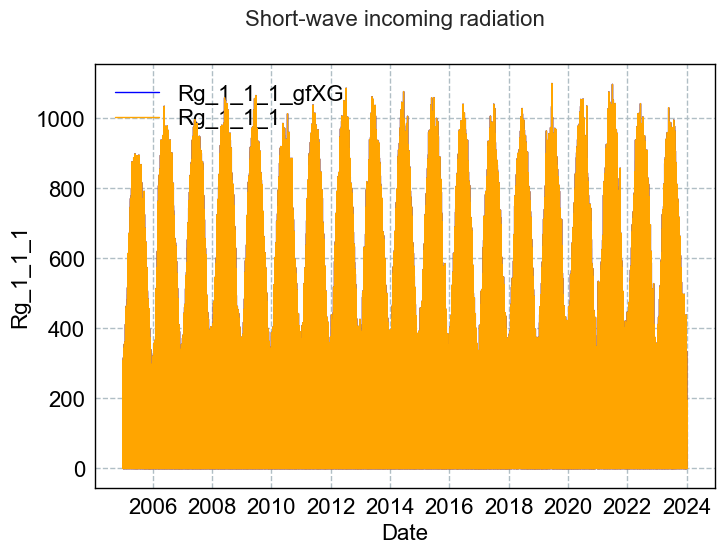

In [18]:
title="Short-wave incoming radiation"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## TA

In [19]:
_df = pd.DataFrame()
_df['Rg_1_1_1_gfXG'] = data_simple_merged['Rg_1_1_1_gfXG'].copy()
_df['Ta_1_1_1'] = data_simple_merged['Ta_1_1_1'].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,Rg_1_1_1_gfXG,Ta_1_1_1,SW_IN_POT
TIMESTAMP_END,,,
2005-01-01 00:30:00,0.0,2.139000,0.0
2005-01-01 01:00:00,0.0,2.126000,0.0
2005-01-01 01:30:00,0.0,2.114000,0.0
2005-01-01 02:00:00,0.0,2.090000,0.0
2005-01-01 02:30:00,0.0,2.066000,0.0
...,...,...,...
2023-12-31 22:00:00,0.0,1.540578,0.0
2023-12-31 22:30:00,0.0,2.051889,0.0
2023-12-31 23:00:00,0.0,2.223067,0.0


In [20]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Ta_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.


In [21]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 01:00:00 and 2023-12-31 23:30:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:6.59551	validation_1-rmse:6.60570
[1]	validation_0-rmse:5.36842	validation_1-rmse:5.38255
[2]	validation_0-rmse:4.60747	validation_1-rmse:4.62478
[3]	validation_0-rmse:4.15000	validation_1-rmse:4.16962
[4]	validation_0-rmse:3.86160	validation_1-rmse:3.88182
[5]	validation_0-rmse:3.68775	validation_1-rmse:3.70513
[6]	validation_0-rmse:3.57054	validation_1-rmse:3.58957
[7]	validation_0-rmse:3.50318	validation_1-rmse:3.52267
[8]	validation_0-rmse:3.45245	validation_1-rmse:3.47242
[9]	validation_0-rmse:3.39528	validation_1-rmse:3.41605
[10]	validation_0-rmse:3.36910	validation_1-rmse:3.39000
[11]	validation_0-rmse:3.32592	validation_1-rmse:3.34690
[12]	validation_0-rmse:3.29815	validation_1-rmse:3.31955
[13]	validation_0-rmse:3.27462	validation_1-rmse:3.29714
[14]	validation_0-r

In [22]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target Ta_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting Ta_1_1_1 ...
>>> Predicting target Ta_1_1_1 where all features are available ... predicted 333072 records.
>>> Collecting results for final model ...
>>> Filling 168 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable Ta_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (168 values, Ta_1_1_1_gfXG where flag=1) in comparison to observed targets (332904 values, Ta_1_1_1).

## TARGET
- first timestamp:  2005-01-01 00:30:00
- last timestamp:  2024-01-01 00:00:00
- potential number of values: 333072 values)
- targe

In [23]:
observed = _df['Ta_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

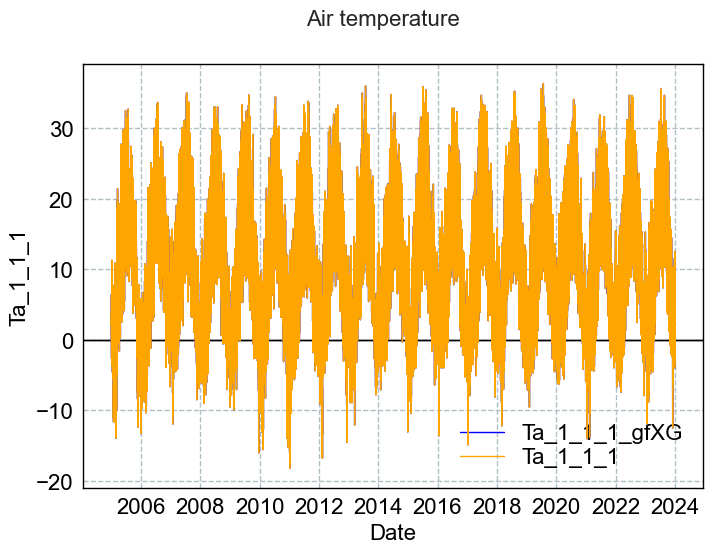

In [24]:
title="Air temperature"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## PPFD

In [25]:
_df = pd.DataFrame()
_df['PPFD_1_1_1'] = data_simple_merged[['PPFD_1_1_1']].copy()
_df['Rg_1_1_1_gfXG'] = data_simple_merged[['Rg_1_1_1_gfXG']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,PPFD_1_1_1,Rg_1_1_1_gfXG,SW_IN_POT
TIMESTAMP_END,,,
2005-01-01 00:30:00,NaN,0.0,0.0
2005-01-01 01:00:00,NaN,0.0,0.0
2005-01-01 01:30:00,NaN,0.0,0.0
2005-01-01 02:00:00,NaN,0.0,0.0
2005-01-01 02:30:00,NaN,0.0,0.0
...,...,...,...
2023-12-31 22:00:00,0.0,0.0,0.0
2023-12-31 22:30:00,0.0,0.0,0.0
2023-12-31 23:00:00,0.0,0.0,0.0


In [26]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='PPFD_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 333072.


In [27]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:30:00 and 2023-12-31 23:30:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:327.58256	validation_1-rmse:325.67309
[1]	validation_0-rmse:230.13948	validation_1-rmse:228.79331
[2]	validation_0-rmse:162.14941	validation_1-rmse:161.19690
[3]	validation_0-rmse:114.86198	validation_1-rmse:114.18435
[4]	validation_0-rmse:82.13953	validation_1-rmse:81.59078
[5]	validation_0-rmse:59.76903	validation_1-rmse:59.32782
[6]	validation_0-rmse:44.73767	validation_1-rmse:44.29595
[7]	validation_0-rmse:34.87971	validation_1-rmse:34.43126
[8]	validation_0-rmse:28.65453	validation_1-rmse:28.18239
[9]	validation_0-rmse:24.91354	validation_1-rmse:24.43539
[10]	validation_0-rmse:22.67328	validation_1-rmse:22.16294
[11]	validation_0-rmse:21.26756	validation_1-rmse:20.75069
[12]	validation_0-rmse:20.45900	validation_1-rmse:19.96147
[13]	validation_0-rmse:19.95037	validation

In [28]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target PPFD_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting PPFD_1_1_1 ...
>>> Predicting target PPFD_1_1_1 where all features are available ... predicted 333072 records.
>>> Collecting results for final model ...
>>> Filling 16494 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable PPFD_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (16494 values, PPFD_1_1_1_gfXG where flag=1) in comparison to observed targets (316578 values, PPFD_1_1_1).

## TARGET
- first timestamp:  2005-01-01 00:30:00
- last timestamp:  2024-01-01 00:00:00
- potential number of values: 333072

In [29]:
observed = _df['PPFD_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

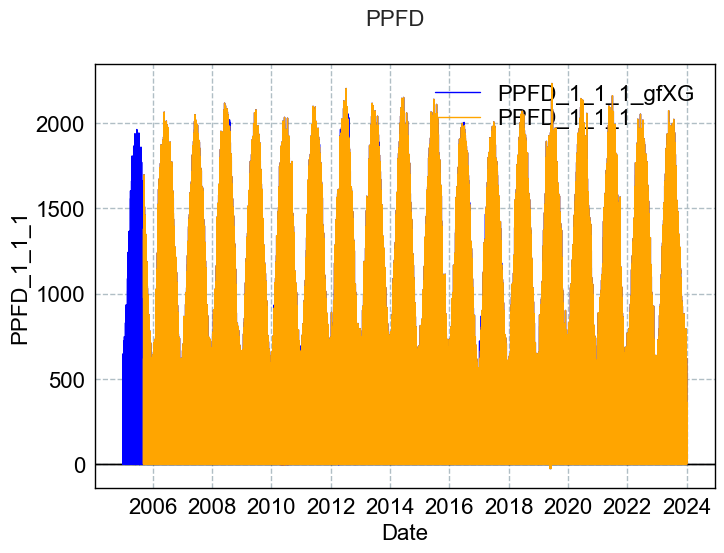

In [30]:
title="PPFD"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

</br>

# **Plots**

In [31]:
_plot_df = data_simple_merged[['Lwin_1_1_1', 'PPFD_1_1_1', 'PPFD_1_1_1_gfXG', 'RH_1_1_1', 'Rg_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1', 'Ta_1_1_1_gfXG', 'Pa_1_1_1']].copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

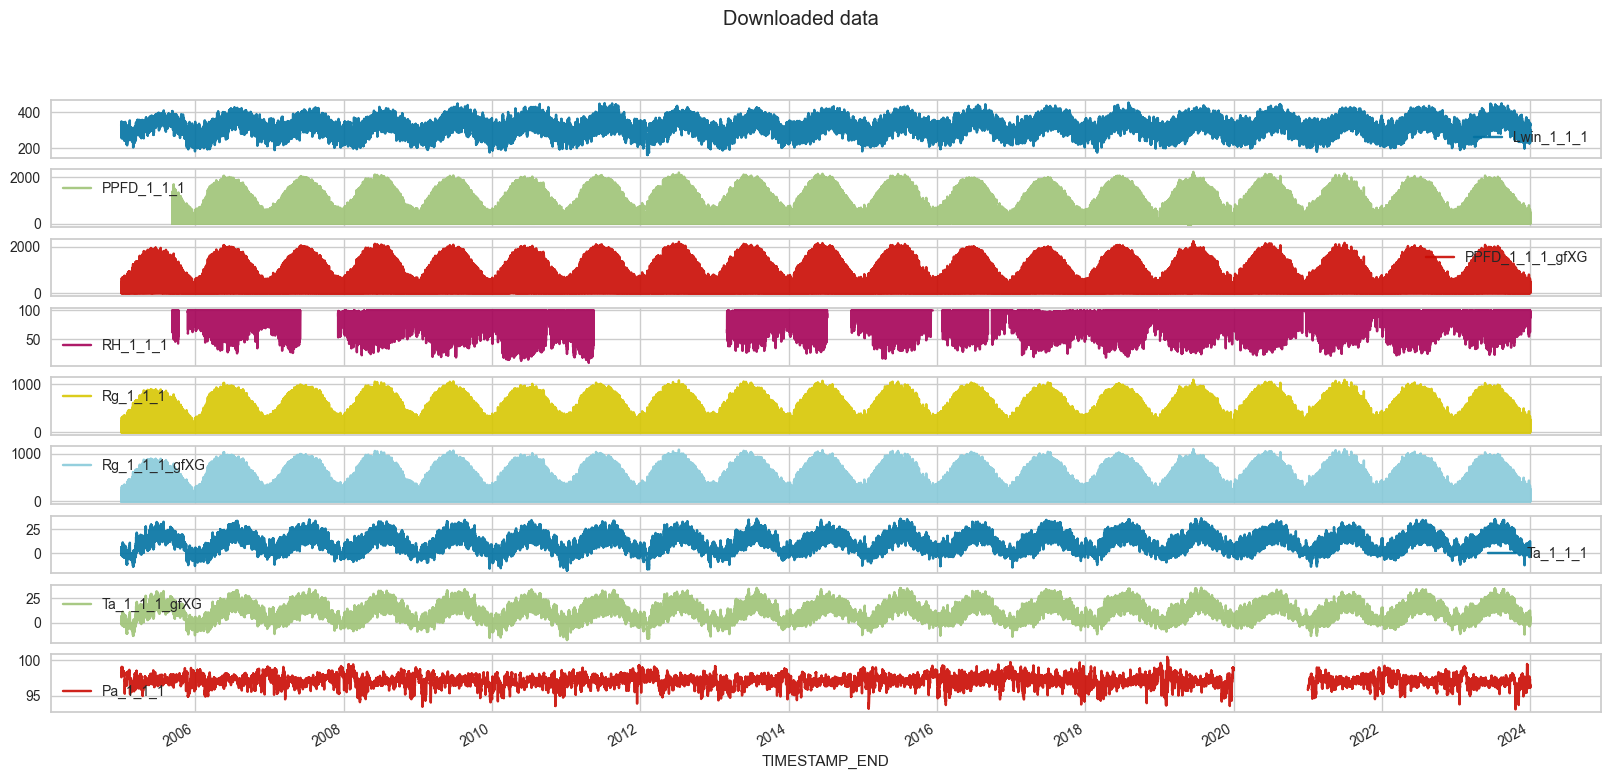

In [32]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

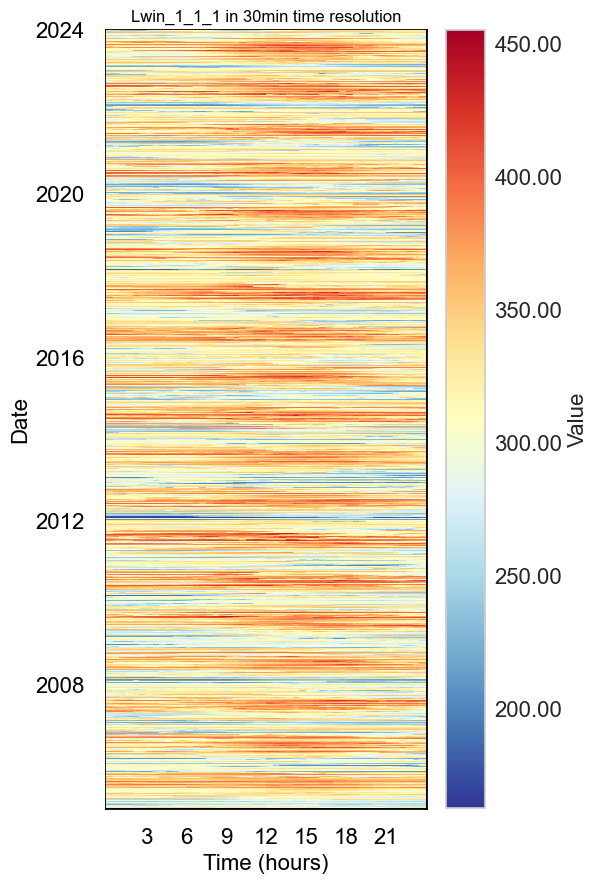

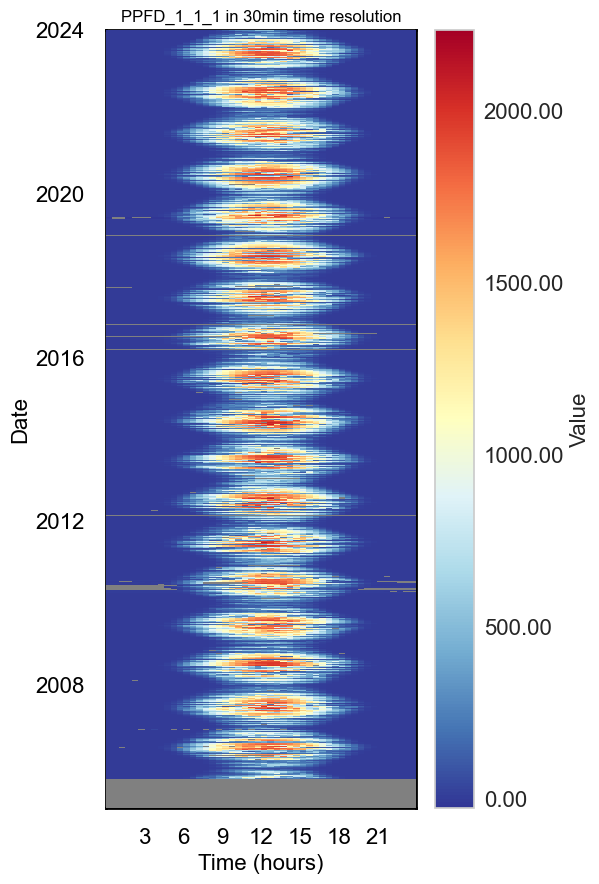

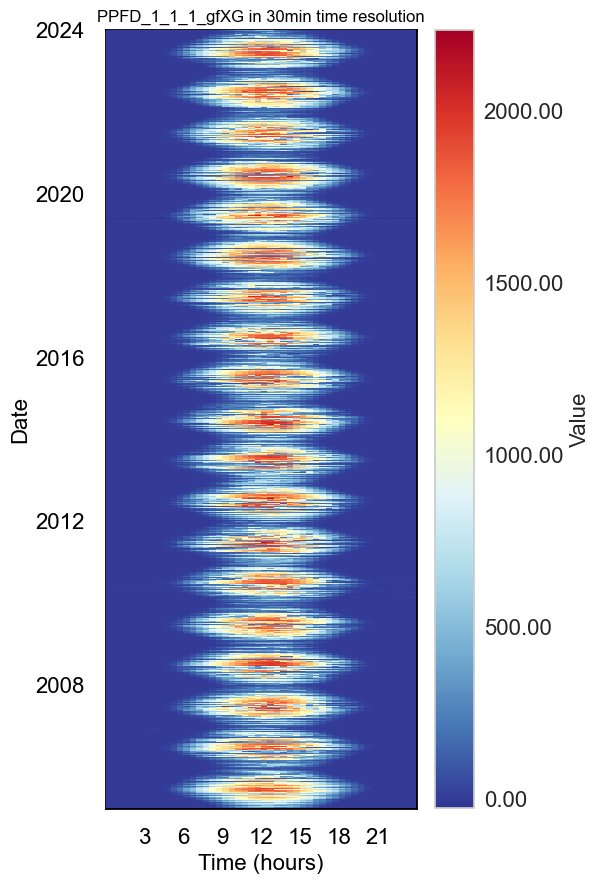

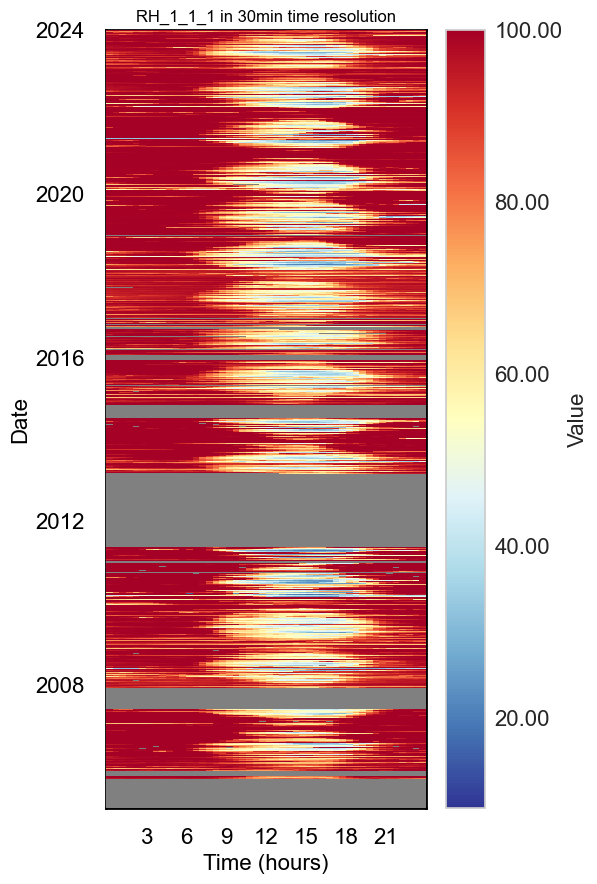

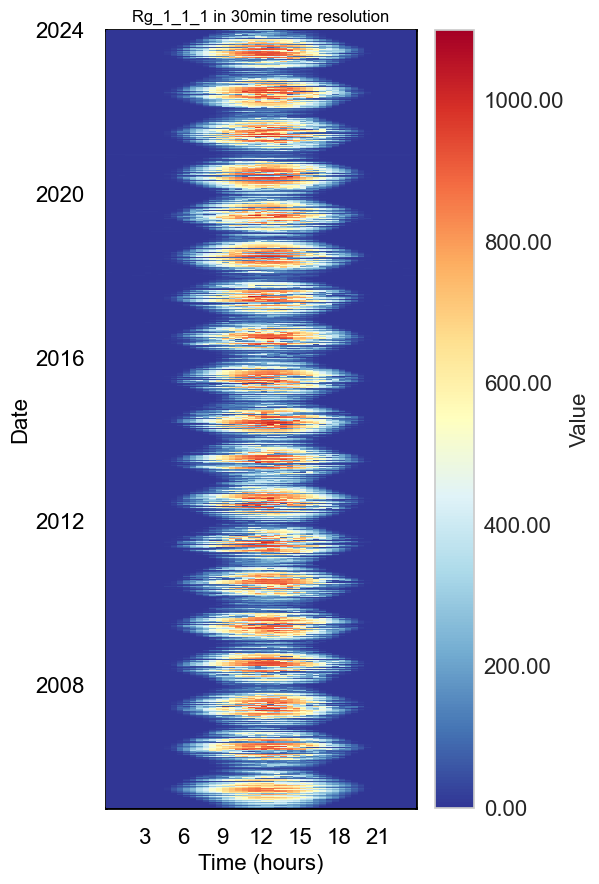

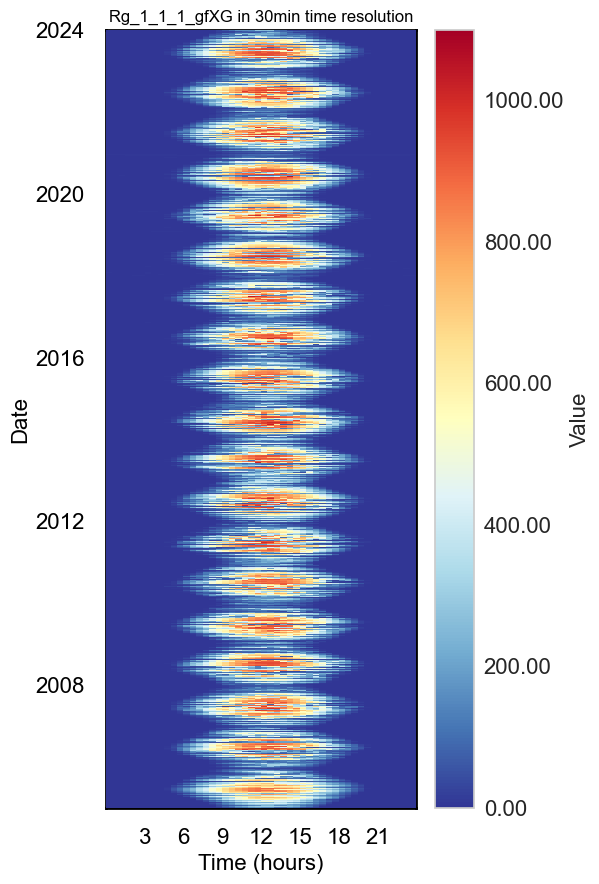

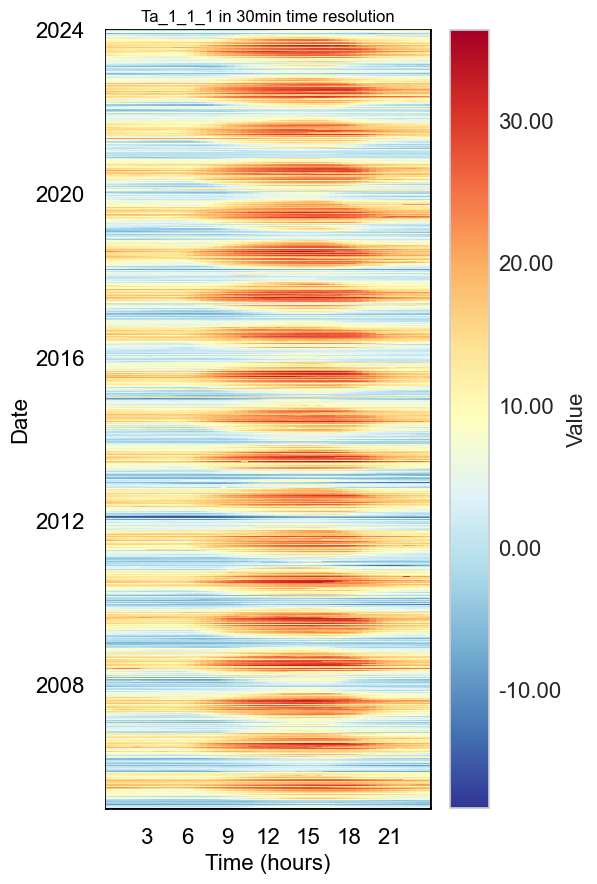

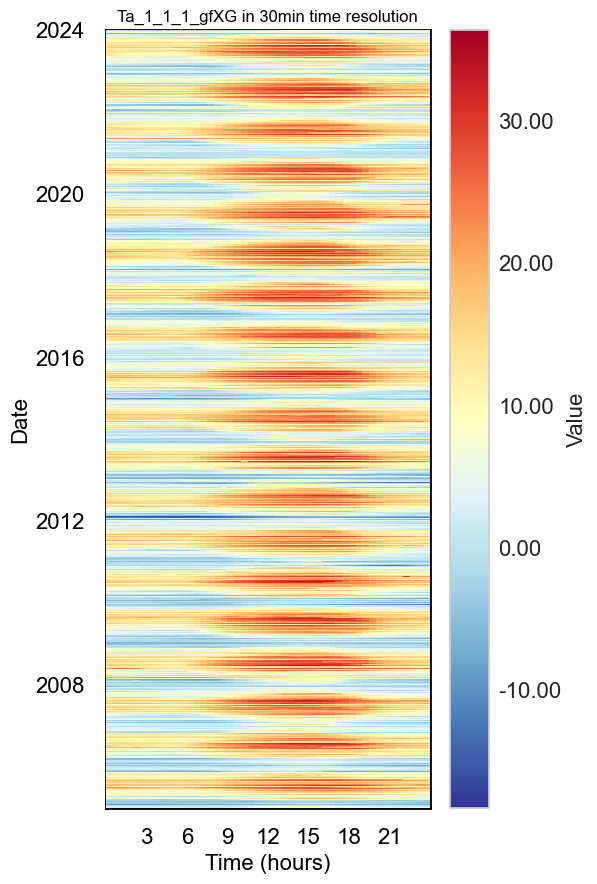

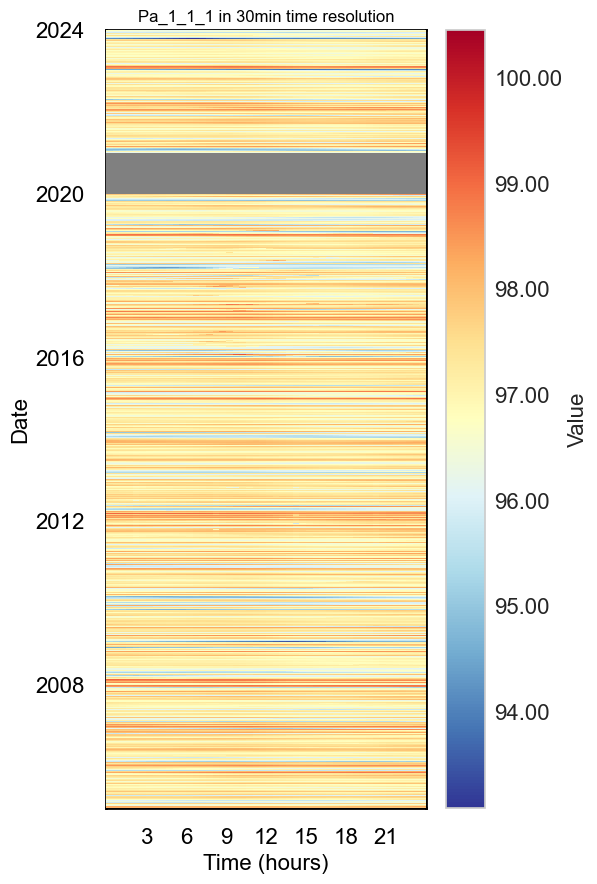

In [33]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# **Stats**

In [34]:
data_simple_merged.describe()

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
count,333034.000000,315469.000000,316578.000000,264676.000000,333060.000000,332904.000000,333072.000000,333072.000000,333072.000000
mean,322.884878,97.101181,280.488366,85.546155,143.169615,9.901087,143.173360,9.906332,283.619781
std,44.062115,0.768875,466.291383,18.844653,235.295199,8.471371,235.295053,8.473298,467.607598
min,162.974000,93.096466,-24.975600,9.561100,0.000000,-18.246000,0.000000,-18.246000,-24.975600
25%,295.387000,96.688000,0.000000,74.562250,0.000000,3.190000,0.000000,3.193000,0.000000
50%,325.636000,97.131000,8.155485,95.756000,3.658000,9.638000,3.661000,9.643000,8.670715
75%,354.383702,97.581000,368.530000,99.902748,191.951000,15.904000,191.962436,15.910000,378.690802
max,454.942000,100.449000,2233.030000,100.000000,1098.310000,36.349000,1098.310000,36.349000,2233.030000


</br>

# **Keep relevant columns**

In [40]:
data_simple_merged.columns

Index(['Lwin_1_1_1', 'Pa_1_1_1', 'PPFD_1_1_1', 'RH_1_1_1', 'Rg_1_1_1', 'Ta_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1_gfXG', 'PPFD_1_1_1_gfXG'], dtype='object')

In [41]:
keepcols = ['Lwin_1_1_1', 'RH_1_1_1', 'Pa_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1_gfXG', 'PPFD_1_1_1_gfXG']
data_simple_merged = data_simple_merged[keepcols].copy()
data_simple_merged

,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.367000,NaN,98.223000,0.0,2.139000,0.002183
2005-01-01 01:00:00,331.367000,NaN,98.229000,0.0,2.126000,0.002183
2005-01-01 01:30:00,324.823000,NaN,98.235000,0.0,2.114000,0.002183
2005-01-01 02:00:00,324.823000,NaN,98.208000,0.0,2.090000,0.002183
2005-01-01 02:30:00,334.816000,NaN,98.181000,0.0,2.066000,0.002183
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407107,99.461884,96.496962,0.0,1.540578,0.000000
2023-12-31 22:30:00,327.958383,98.875075,96.504955,0.0,2.051889,0.000000
2023-12-31 23:00:00,328.605910,97.569925,96.526105,0.0,2.223067,0.000000


</br>

# **Add timestamp columns for EddyPro**

In [42]:
# EddyPro needs two columns: date and time
data_simple_merged['date'] = data_simple_merged.index.date
data_simple_merged['date'] = data_simple_merged['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

data_simple_merged['time'] = data_simple_merged.index.time
data_simple_merged['time'] = data_simple_merged['time'].apply(lambda x: x.strftime('%H:%M'))

# Move date and time columns to start of dataframe
col = data_simple_merged.pop('date')
data_simple_merged.insert(0, col.name, col)
col = data_simple_merged.pop('time')
data_simple_merged.insert(1, col.name, col)

data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
TIMESTAMP_END,,,,,,,,
2005-01-01 00:30:00,2005-01-01,00:30,331.367000,NaN,98.223000,0.0,2.139000,0.002183
2005-01-01 01:00:00,2005-01-01,01:00,331.367000,NaN,98.229000,0.0,2.126000,0.002183
2005-01-01 01:30:00,2005-01-01,01:30,324.823000,NaN,98.235000,0.0,2.114000,0.002183
2005-01-01 02:00:00,2005-01-01,02:00,324.823000,NaN,98.208000,0.0,2.090000,0.002183
2005-01-01 02:30:00,2005-01-01,02:30,334.816000,NaN,98.181000,0.0,2.066000,0.002183
...,...,...,...,...,...,...,...,...
2023-12-31 22:00:00,2023-12-31,22:00,327.407107,99.461884,96.496962,0.0,1.540578,0.000000
2023-12-31 22:30:00,2023-12-31,22:30,327.958383,98.875075,96.504955,0.0,2.051889,0.000000
2023-12-31 23:00:00,2023-12-31,23:00,328.605910,97.569925,96.526105,0.0,2.223067,0.000000


</br>

# **Add units for EddyPro input file**

In [43]:
renaming_dict = {
    'date': ('date', 'yyyy-mm-dd'),
    'time': ('time', 'HH:MM'),
    'Lwin_1_1_1': ('Lwin_1_1_1', 'W+1m-2'),
    'PPFD_1_1_1_gfXG': ('PPFD_1_1_1', 'umol+1m-2s-1'),
    'RH_1_1_1': ('RH_1_1_1', '%'),
    'Rg_1_1_1_gfXG': ('Rg_1_1_1', 'W+1m-2'),
    'Ta_1_1_1_gfXG': ('Ta_1_1_1', 'C'),
    'Pa_1_1_1': ('Pa_1_1_1', 'kPa')
}
data_simple_merged = data_simple_merged.rename(columns=renaming_dict)
data_simple_merged.columns = pd.MultiIndex.from_tuples(data_simple_merged.columns)
data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1,Ta_1_1_1,PPFD_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,%,kPa,W+1m-2,C,umol+1m-2s-1
TIMESTAMP_END,,,,,,,,
2005-01-01 00:30:00,2005-01-01,00:30,331.367000,NaN,98.223000,0.0,2.139000,0.002183
2005-01-01 01:00:00,2005-01-01,01:00,331.367000,NaN,98.229000,0.0,2.126000,0.002183
2005-01-01 01:30:00,2005-01-01,01:30,324.823000,NaN,98.235000,0.0,2.114000,0.002183
2005-01-01 02:00:00,2005-01-01,02:00,324.823000,NaN,98.208000,0.0,2.090000,0.002183
2005-01-01 02:30:00,2005-01-01,02:30,334.816000,NaN,98.181000,0.0,2.066000,0.002183
...,...,...,...,...,...,...,...,...
2023-12-31 22:00:00,2023-12-31,22:00,327.407107,99.461884,96.496962,0.0,1.540578,0.000000
2023-12-31 22:30:00,2023-12-31,22:30,327.958383,98.875075,96.504955,0.0,2.051889,0.000000


</br>

# **Set missing values code** to -9999

In [44]:
# EddyPro needs missing values as -9999
data_simple_merged = data_simple_merged.fillna(-9999)
data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1,Ta_1_1_1,PPFD_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,%,kPa,W+1m-2,C,umol+1m-2s-1
TIMESTAMP_END,,,,,,,,
2005-01-01 00:30:00,2005-01-01,00:30,331.367000,-9999.000000,98.223000,0.0,2.139000,0.002183
2005-01-01 01:00:00,2005-01-01,01:00,331.367000,-9999.000000,98.229000,0.0,2.126000,0.002183
2005-01-01 01:30:00,2005-01-01,01:30,324.823000,-9999.000000,98.235000,0.0,2.114000,0.002183
2005-01-01 02:00:00,2005-01-01,02:00,324.823000,-9999.000000,98.208000,0.0,2.090000,0.002183
2005-01-01 02:30:00,2005-01-01,02:30,334.816000,-9999.000000,98.181000,0.0,2.066000,0.002183
...,...,...,...,...,...,...,...,...
2023-12-31 22:00:00,2023-12-31,22:00,327.407107,99.461884,96.496962,0.0,1.540578,0.000000
2023-12-31 22:30:00,2023-12-31,22:30,327.958383,98.875075,96.504955,0.0,2.051889,0.000000


</br>

# **Save to file**

In [45]:
data_simple_merged.to_csv(OUTFILE, index=False)

</br>

# **End of notebook**.

In [46]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-07-04 15:04:26


</br>

# (Bonus)

In [71]:
# ta = data_simple_merged[('Ta_1_1_1', 'C')].copy()
# ta = TimestampSanitizer(data=ta).get()
# ta = ta.loc[ta.index.year > 2005].copy()
# means = ta.groupby(ta.index.year).mean()
# means

In [72]:
# means.sort_values(ascending=False).head(5)

In [73]:
# means.loc[means.index > 2014].mean()